# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [ ]:
from collections import Counter
import copy
import os
import kagglehub
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Carga y preprocesamiento del dataset

Carga y preprocesamiento del dataset TrashNet.

In [ ]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet", force_download=False)
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

full_dataset = datasets.ImageFolder(root=dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

100%|██████████| 40.8M/40.8M [00:03<00:00, 14.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### Ejecución del modelo entrenado
Tomamos el Modelo Efficientnet_bo entrenado con  los mejores parámetros obtenidos y hacemos predicciones de 6 imagenes de cada clase elegidas al azar.

In [ ]:
def create_empty_model(num_classes):
    model = timm.create_model("efficientnet_b0", pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

In [ ]:
model = create_empty_model(num_classes=6)
model.load_state_dict(torch.load("output/trashnet_efficientnet_b0_model.pth", map_location=device))
model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
def predict_one_image_per_class(dataset_path, model, class_names, device):
    model.eval()
    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if not images:
            print(f"No hay imágenes en la clase {class_name}")
            continue
        img_name = random.choice(images)
        img_path = os.path.join(class_folder, img_name)

        pred_class, confidence = predict_image(img_path, model, class_names, device)

        # Mostrar imagen
        image = Image.open(img_path).convert("RGB")
        plt.imshow(image)
        plt.title(f"Real: {class_name} | Predicción: {pred_class} ({confidence:.4f})")
        plt.axis('off')
        plt.show()


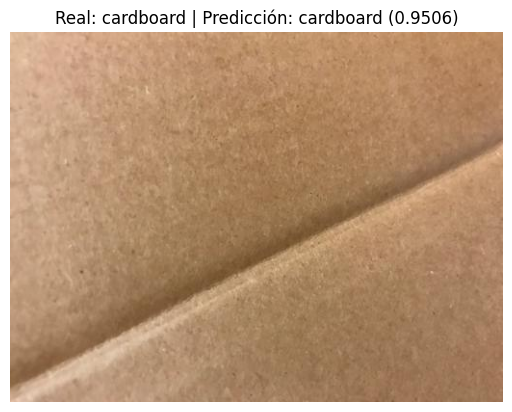

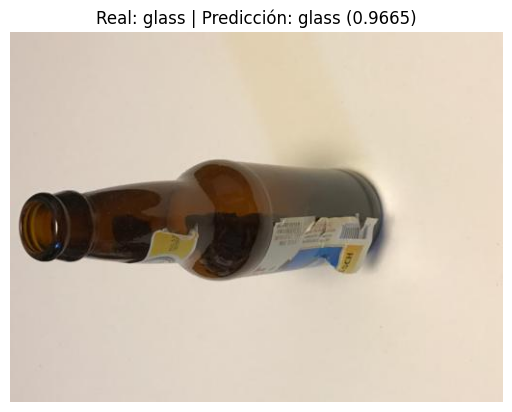

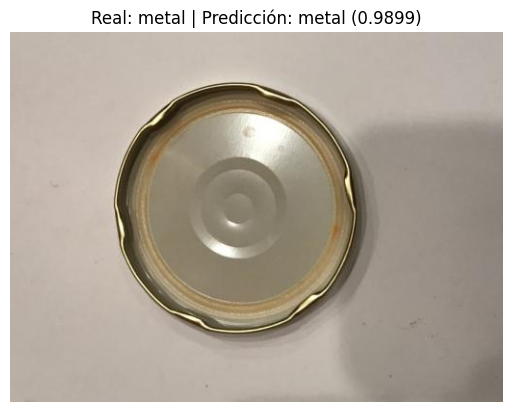

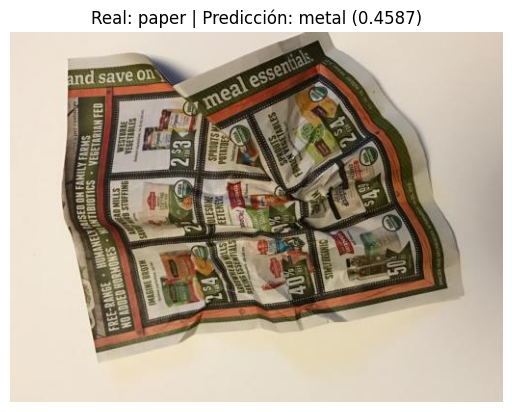

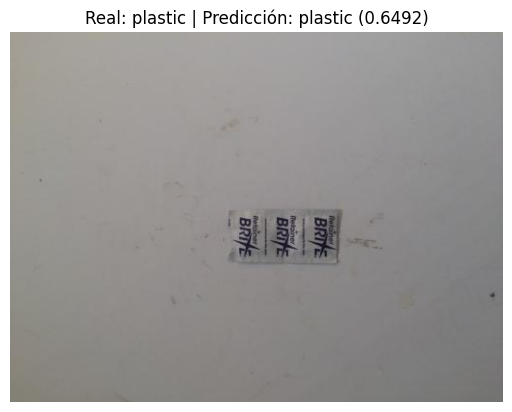

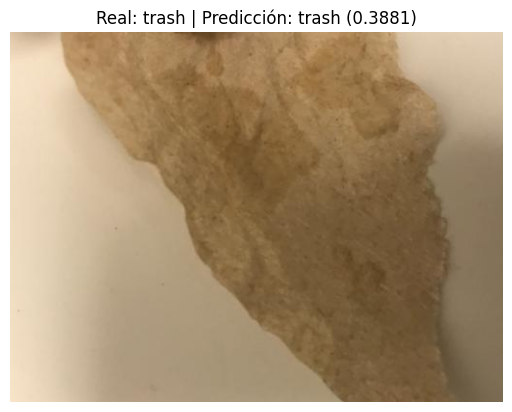

In [ ]:
predict_one_image_per_class(dataset_path, model, class_names, device)

**Conclusión:** de las 6 imagenes elegidas al azar solo una estuvo mal. Eficiencia: 84%